# Produce two and three knock-downs recommendations

This notebook explains how to produce recommendations for knockdown of two and three genes for the CRISPRi project with David Carruthers and Taek Soon Lee. 

Tested using "ART Prod v.master.535f34c" kernel on skynet.ese.lbl

## Input and output

Required files to run this notebook:

- ``Sample name, CRISPRi target gene, Uniprot ID v2.xlsx`` : file with mapping from Uniprot protein IDs to PP_XXXX gene numbers
- ``sample injection order.xlsx`` : File mapping the runs to the batch they were run in.

Files generated by running this notebook:

- ``CRISPRi_double_targets.csv`` : file with double knock-down recommendations
- ``CRISPRi_triple_targets.csv`` : file with triple knock-down recommendations

Output plots generated by running this notebook:

- `titer_cv.png`: image of all targets with their isoprenol production and %CV plotted
- `crispri_proteomics.png`: For several proteins, the distribution of all measurements in the library, the control strain, and the CRISPRi target strain
- `crispri_high_producers.png`: The above figure, but for the 20 highest producing targets used for selection.
- `target_filter_results.png`: For each CRISPRi target, a plot of their isoprenol titer and various measures of CRISPRi efficacy showing how CRISPRi filters remove specific targets.

## 1. Setup

### 1.1 Imports

In [1]:
import edd_utils as eddu
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re 
import random
random.seed(42)

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Define function for identifying if tests pass throughout the workbook: 

Test: sample test passed


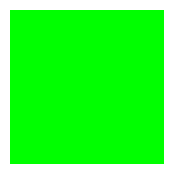

In [2]:
def display_test_passage(condition, test_name):
    color_image = np.zeros((1,1,3))
    if condition: #green if true
        color_index = 1
        test_string = f'Test: {test_name} passed'
    else: #red if false
        color_index = 0
        test_string = f'Test: {test_name} failed'

    color_image[:, :, color_index] = 1
    plt.figure(figsize = (2,2))
    plt.imshow(color_image)
    plt.axis('off')
    print(test_string)
display_test_passage('a' == 'a', 'sample test')

### 1.2 User parameters

In [3]:
user_params = {
    'output_dir'  : './results',
    'protein_map' : './data/Sample name, CRISPRi target gene, Uniprot ID v2.xlsx',
    'double_targets_file': f'./data/CRISPRi_double_targets.csv',
    'triple_targets_file': f'./data/CRISPRi_triple_targets.csv',
    'run_list' : f'./data/sample injection order.xlsx',
    'n_instances_double': 30,
    'n_instances_triple': 30
}

### 1.3 Download the data

These are the [Experiment Data Depot](https://pubs.acs.org/doi/full/10.1021/acssynbio.7b00204) server, the corresponding username and the slug (address) for the study to be downloaded:

In [4]:
study_slug_1 = 'crispri-automation-for-isoprenol-production-in-p-p'
edd_server   = 'edd.jbei.org'
username     = 'pckinnunen'

We try connecting to the server with our login and password:

In [5]:
try:
    session = eddu.login(edd_server=edd_server, user=username)
except:
    print('ERROR! Connection to EDD failed. We will try to load data from disk...')
else:
    print('OK! Connection to EDD successful. We will try to load data from EDD...')

Password for pckinnunen:  ········


OK! Connection to EDD successful. We will try to load data from EDD...


And then we try to export the study from the EDD instance:

In [ ]:
try:
    df = eddu.export_study(session, study_slug_1, edd_server=edd_server)
except (NameError, AttributeError, KeyError):
    print(f'ERROR! Not able to export the study.')

 79%|███████▉  | 938993/1182270 [00:46<00:13, 18033.37it/s]

There are lots of data here (particularly the biolector data takes a lot of space):

Let's have a look at the different protocols (types of data) that are includeed in the study:

In [ ]:
df['Protocol'].unique()

## 2. Preprocess and inspect data

### 2.1 Useful functions - preprocessing

In [ ]:
def create_strain_names(df: pd.DataFrame):
    "Creates strain names by reading Line Description and eliminating Biolector culture info."
    strains = [
        line_name.split('_')[1] for line_name in df["Line Description"].to_list()
    ]
    return strains

### 2.2 Eliminate biolector data

For our current purposes, we don't need the biolector data, so let's get rid of it (we can always recover it later):

In [ ]:
df['Protocol']=='Biolector'

In [ ]:
df2 = df.loc[df['Protocol']!='Biolector']

And we still have over a million entries of data:

In [ ]:
df2.shape

Let's just keep the basic data types:

In [ ]:
df2 = df2.loc[:,['Line Name', 'Line Description', 'Protocol','Formal Type', 'Measurement Type', 'Value']]

Let's have a look a the lines we have here:

In [ ]:
line_desc = df2['Line Description'].unique()
len(line_desc), line_desc

In [ ]:
line_name = df2['Line Name'].unique()
len(line_name), line_name

In [ ]:
df2['Formal Type'].unique()

In [ ]:
df2['Protocol'].unique()

In [ ]:
df2[df2['Protocol']=='GC-FID']['Measurement Type'].unique()

### 2.2 Add strain name to dataframe using prebuilt function.

In [ ]:
df2["Strain"] = create_strain_names(df2)
print(df2.shape)

### 2.3 Bring out Uniprot names

In [ ]:
get_Uniprot = lambda x: re.sub('.*\|(.*)\|.*', r'\1', x)
get_uniprot_teststring = 'sp|Q9Z408|CSD_PSEPK Csda'
print(f'test string to extract uniprot: {get_uniprot_teststring} \nfunction output: {get_Uniprot(get_uniprot_teststring)}')

In [ ]:
df2['Formal Type'] = df2['Formal Type'].apply(get_Uniprot)
df2.head()

In [ ]:
print(df2.shape)

### 2.4 Limit protein data to target genes. 
Since we only need the proteomics data for the target genes, we will only keep that. To figure out the target genes, we need to get the file mapping Uniprot IDs to PPxx names for the target genes:

In [ ]:
ProtMapping_df = pd.read_excel(user_params['protein_map'])
ProtMapping_df.head()

We will limit CRISPRi target gene name to standard names (e.g. we will convert 'PP_1607_NT2' to 'PP_1607')

In [ ]:
ProtMapping_df["CRISPRi target gene"] = ProtMapping_df["CRISPRi target gene"].apply(lambda x: x[0:7])

#### 2.4.1 Protein-gene mapping sanity check
Need to check: is there a 1 to 1 correspondence between target genes and uniprot IDs?

There should be several targets and genes that have multiple entries due to trying multiple guide RNAs/constructs, but the number of duplicate target genes and duplicate UNIPROT IDs should match and have the same number of duplicates. Note also that according to uniprot, UPID Q877U6 is associated with genes PP1157 and PP3365. https://www.uniprot.org/uniprotkb/Q877U6/entry

In [ ]:
number_crispr_target_genes = len(ProtMapping_df["CRISPRi target gene"].unique())
number_uniprot_id = len(ProtMapping_df["UNIPROT ID"].unique())
target_value_counts = ProtMapping_df["CRISPRi target gene"].value_counts()
upid_value_counts = ProtMapping_df['UNIPROT ID'].value_counts()

print(f'In the Protein Mapping spreadsheet, there are {number_crispr_target_genes} unique target genes and {number_uniprot_id} unique uniprot IDs')
print('These targets show up multiple times in the uniprot list:')
print(target_value_counts[target_value_counts>1])
print('These Uniprot IDs show up multiple times in the target list')
print(upid_value_counts[upid_value_counts>1])


### 2.5 Drop non-target proteins

In [ ]:
targets_in_mapping = ProtMapping_df['UNIPROT ID'].unique().tolist()
df2 = df2.drop(
                    index=df2[(~df2['Formal Type'].isin(targets_in_mapping)) &
                                  (df2['Protocol']=='Global Proteomics')].index)
print(df2.shape)

In [ ]:
len(targets_in_mapping)

### 2.6 Change names from Uniprot to PP_ names
Create a protein mapping dictionary that translates from Uniprot to PP names:

In [ ]:
uniprot_to_pp = {}
for index in ProtMapping_df.index:
    uniprot_to_pp[ProtMapping_df.loc[index,"UNIPROT ID"]] = ProtMapping_df.loc[index,"CRISPRi target gene"]

Do the translation:

In [ ]:
proteomics_ind = df2['Protocol']=='Global Proteomics'
df2.loc[proteomics_ind,'Formal Type'] = df2.loc[proteomics_ind,'Formal Type'].apply(lambda x: uniprot_to_pp[x])

### 2.7 Add Target Gene
Add column with a target gene for each strain.

In [ ]:
get_target_gene = lambda x: re.split('-', x)[0][0:7] # last part eliminates non standard names from PP name (e.g. PP_1607_NT3)
get_target_gene_teststring = 'PP_4549-R1'
print(f'To get target gene:\n Input string: {get_target_gene_teststring}, output: {get_target_gene(get_target_gene_teststring)}')

In [ ]:
df2['Target'] = df2['Line Name'].apply(get_target_gene)
df2.head()

### 2.8 Normalize based on batch

Proteomics for different strains were run in 3 separate batches, and there was batch-to-batch variation in the detector efficiency. There were control strains ran in each batch. Thus, we normalize each strain to the control strains in each batch.  
- Check to make sure each entry in df2['Line Name'] matches an entry in the order spreadsheet
- Pull out controls from each batch
- Get rid of proteins missing from controls
- Normalize each run by control mean
- Compare the distributions of normalized and unnormalized proteins

#### 2.8.1 Assign batches to measurements

Import order of runs.

In [ ]:
df_order = pd.read_excel(user_params['run_list'])
df_order.head()

Make a sample->batch dictionary


In [ ]:
batch_dict = dict(df_order.values)

Check that sample names match between EDD and spreadsheet

In [ ]:
unique_sample_names_order = df_order['Sample Name in order injected'].unique().sort()
unique_sample_names_df2 = df2['Line Name'].unique().sort()
display_test_passage(unique_sample_names_df2 == unique_sample_names_order, 'Run order names match EDD names')

#### 2.8.2 Identify controls

We find the control strains by looking for the 'ontrol' string in the line name (using instead of 'Control' or 'control' to avoid capitalization issues), and we add the information as a new column:

In [ ]:
find_control   = lambda x: True if 'ontrol' in x else False 
df2['Control'] =  df2['Line Name'].apply(find_control)

Add experimental batch to dataframe.

In [ ]:
find_batch = lambda x: batch_dict[x]
df2['Batch'] = df2['Line Name'].apply(find_batch)

In [ ]:
df2

Print the batch for each control - they aren't uniformly distributed.

In [ ]:
for ii in range(1,4):
    print(f'Controls in batch {ii}: {df2[(df2["Batch"] == ii) & (df2["Control"])]["Line Name"].unique()}')

#### 2.8.3 Drop proteins with missing controls
Some proteins have missing measurements in one or more batches, so we can't normalize them.

Check how many different analytes are measured in controls.

In [ ]:
print(f'There are {len(df2.loc[df2["Control"], "Measurement Type"].unique())} unique analytes in the control dataframe')

Create pivot table based on batch number. 

In [ ]:
control_batch_pivot = pd.pivot_table(df2[df2['Control']], values = 'Value', columns = 'Batch', index = 'Formal Type', aggfunc = np.mean)
control_batch_pivot

Check for NaN measurements in control runs. 

In [ ]:
print(f'There are: {sum(control_batch_pivot.isna())} NaNs in measurement pivot table')

In [ ]:
any_measurement_missing = np.where(np.any(control_batch_pivot.isna(), 1))
control_batch_pivot.iloc[any_measurement_missing][:]

In [ ]:
df2

Get measurement types that have all their control values. 

In [ ]:
control_batch_pivot = control_batch_pivot.dropna() 
list_of_control_type = control_batch_pivot.index.values.tolist()
check_norm_exist = lambda x: 1 if x in list_of_control_type else 0
df2['can_normalize'] = df2['Formal Type'].apply(check_norm_exist)
df2

Drop measurements that can't be normalized. 

In [ ]:
df2 = df2[df2['can_normalize'] == 1]
df2.shape

#### 2.8.4. Normalize runs by batch

Need to divide each measurement the correct batch control mean. Create column for holding the control mean and fill it in with lambda function.

In [ ]:
df2['control_mean'] = np.nan
#Iterate through batch numbers [1,2,3]
for ii in range(1,4):
    add_correct_normalization_value = lambda x: control_batch_pivot[ii][x]
    current_batch_idx = df2['Batch'] == ii
    df2.loc[current_batch_idx, 'control_mean'] = df2[current_batch_idx]['Formal Type'].apply(add_correct_normalization_value)

Add column to dataframe and fill it with normalized values. Don't normalize isoprenol since it was not affected by batch variation. Isoprenol was measured using GC, not mass spec.

In [ ]:
df2['norm_value'] = np.nan
index_to_normalize = df2['Protocol'] == 'Global Proteomics'
index_not_normalized = df2['Protocol'] != 'Global Proteomics'
df2.loc[index_to_normalize, 'norm_value'] = df2.loc[index_to_normalize, 'Value']/df2.loc[index_to_normalize, 'control_mean']
df2.loc[index_not_normalized, 'norm_value'] = df2.loc[index_not_normalized, 'Value']
df2.head()

### 2.9 Visualize normalization effects

#### 2.9.1 Functions for visualizing batch effects

Functions generate swarm plots grouped by batch with individual datapoints represented by blue dots and the mean of each group down with a red dash.

In [ ]:
def compare_swarm(df, measurement_type, batches, ax = None, to_plot = 'Value'):
    if ax is None:
        fig, ax = plt.subplots(figsize = (len(batches), 5))
    df = df[df['Batch'].isin(batches)]
    sns.stripplot(df[df['Measurement Type'] == measurement_type], x = 'Batch', y = to_plot, alpha = 0.5)
    
    #Add mean as red dot
    mean_vals = [np.mean(df[(df['Measurement Type'] == measurement_type) & (df['Batch'] == batch_num)][to_plot]) for batch_num in batches]
                    
    [ax.scatter(i, mean_vals[i], color = 'red', marker = '_', s = 100, zorder = 10) for i in range(len(batches))]
    plt.title(measurement_type)

def compare_swarm_multi(df, measurement_type, batches, to_plot = 'Value'):
    n_measures = len(measurement_type)
    fig = plt.figure(figsize=(15, 5*np.ceil(len(measurement_type)/6)))
    fig.subplots_adjust(hspace=0.3, wspace=0.6)
    #fig.suptitle('Comparing batches')
    
    for ii, m in enumerate(measurement_type):
        ax = fig.add_subplot(int(np.ceil(len(measurement_type)/6)), 6, (ii+1))
        compare_swarm(df, m, batches, ax, to_plot = to_plot)
        ax.set_title(m.replace(' ', '\n', 1))
    return fig

This function plots the distribution of differences between different batches of data for all proteins in the dataset.

In [ ]:
def plot_distribution_of_differences(meas_pivot, comparisons, labels):
    """
    Take a pivot table of measurements in and plot distributions of comparisons between batches.
    """
    n_comparisons = len(comparisons)
    fig, ax = plt.subplots(nrows = 1, ncols = n_comparisons)
    for ii in range(n_comparisons):
        dif_current = meas_pivot[comparisons[ii][0]] - meas_pivot[comparisons[ii][1]]
        sns.histplot(dif_current, ax = ax[ii])
        ax[ii].set_xlabel(labels[ii])
    return fig, ax       

#### 2.9.2 Swarmplots of controls
Plot the measurements of individual controls (blue dots) and the batch mean of the control (red line) between batches using a swarm plot. 

In [ ]:
target_list_all = df2[df2['Control']]['Measurement Type'].unique().tolist()
control_swarm_fig = compare_swarm_multi(df2[df2['Control']], target_list_all[:12], [1,2,3])

#### 2.9.3 Distribution of differences
Calculating change in counts for (batch 3) - (batch 1) should skew negative for unnormalized data, but should go away with normalization.

Make pivot tables for normalized an unnormalized data and set up labels. 

In [ ]:
proteomics_control_batch_means = pd.pivot_table(df2[df2['Control']], values = ['Value', 'norm_value'], columns = 'Batch', index = 'Measurement Type', aggfunc = np.mean)
dif_to_plot = [[3, 1],
               [2, 1]]
dif_labels = ['Batch 3 - Batch 1',
              'Batch 2 - Batch 1']
proteomics_control_batch_means

Make plots to show the distribution of differences. 

In [ ]:
fig, ax = plot_distribution_of_differences(proteomics_control_batch_means['Value'], dif_to_plot, dif_labels)
ax_lim = 5e7
[ax[ii].set_xlim([-ax_lim, ax_lim]) for ii in range(len(ax))]
fig.suptitle('Non-normalized Control')

#### 2.9.4 Swarmplots for all proteins
These swarmplots compare the distribution of all proteins in each batch before and after normalization. We can see that the normalization makes the difference in distributions much less. 



In [ ]:
target_list_filter = df2['Measurement Type'].unique().tolist()
unnorm_fig = compare_swarm_multi(df2, target_list_filter[:12], [1,2,3], to_plot='Value')
unnorm_fig.suptitle('Non-normalized Proteomics - all lines', fontweight = 'bold')
norm_fig = compare_swarm_multi(df2, target_list_filter[:12], [1,2,3], to_plot='norm_value')
norm_fig.suptitle('Normalized Proteomics - all lines', fontweight = 'bold')

## 3. Statistical Analysis
### 3.1 Pivot dataframe to target table:

Pivot dataframe to table with strain as the row name, columns as the gene, and proteomics values as the value. Create one for normalized values and one for non-normalized values.

In [ ]:
df_targets = df2.pivot_table(
    index = "Strain", columns = "Formal Type", values = "norm_value", aggfunc = np.mean)


Check values for control after normalization - should all be 1

In [ ]:
normed_controls = df_targets.loc['NT',:]
non_unity_strains = normed_controls[abs(normed_controls.values-1.00)>0.000001].index[:-1].values
print(f'Strains where controls are not one:{non_unity_strains}')
display_test_passage(len(non_unity_strains) == 0, 'Control strains normalized to 1')

In [ ]:
df_targets.head()

Change compound ID to Isoprenol

In [ ]:
df_targets.rename(columns = {'cid:12988': 'Isoprenol mean'}, inplace = True)
df_targets.head()

Add the target genes to this table - create a map from the strains and targets in df2.

In [ ]:
target_map = df2[['Strain', 'Target']].drop_duplicates().set_index("Strain")
target_map

In [ ]:
df_targets.loc[target_map.index, 'Target'] = target_map['Target']
df_targets

Some target genes are not present in the proteomics data:

In [ ]:
print('Genes missing from proteomics data:')
for gene, titer in zip(df_targets['Target'], df_targets['Isoprenol mean']):
    if gene not in df_targets.columns:
        print(f'gene: {gene}\ttiter: {titer}')

### 3.2 Add Proteomics Stats

Now we can add the statistical data from the proteomics data (mean, std, first and third quantile):

In [ ]:
def find_library_stats(df):
    """Find mean, std and quartiles of the target transcription level from the whole library excluding the target strain"""
    
    stat_names = ['Library_mean', 'Library_std', 'Library_Q1', 'Library_Q3']
    for n in stat_names:
        df.loc[n] = None
        df.loc[n].astype('float64')

    no_data =[]
    for target in df['Target'].dropna():
        if target in df.columns:
            # Exclude the target strain from the mean
            ind = df.index[df['Target']==target].tolist()       
            ind.extend(stat_names)

            mean = df.drop(index=ind)[target].mean()
            df.loc['Library_mean', target] = mean

            std = df.drop(index=ind)[target].std()
            df.loc['Library_std', target] = std

            q1 = df.drop(index=ind)[target].quantile(.25)
            q3 = df.drop(index=ind)[target].quantile(.75)
            df.loc['Library_Q1', target] = q1
            df.loc['Library_Q3', target] = q3
        else:
            #no_data.append((df_targets[df_targets.loc[:,"Target"]==target].index.tolist(),target))
            no_data.append(target)
            
    print("Data for these "+str(len(no_data))+" proteins was not present:")
    print(no_data)
            
        
    return df

In [ ]:
df_targets = find_library_stats(df_targets)
df_targets.head()

### 3.3 Add Isoprenol production data

Find CV for isoprenol production.

Create dataframe for isoprenol production and sort

In [ ]:
df_isoprenol             = df2[df2['Measurement Type']=='3-METHYL-3-BUTEN-1-OL']
df_isoprenol             = df_isoprenol.drop(columns=['Line Name', 'Line Description', 'Measurement Type', 'Protocol','Control', 'Batch', 'can_normalize', 'control_mean', 'norm_value', 'Formal Type'])
product = 'Isoprenol'
df_isoprenol.rename(columns={'Value': product}, inplace=True)
df_isoprenol = df_isoprenol.sort_values(product, ascending=False)
df_isoprenol

Extract statistics (standard deviation and %CV) on isoprenol production

In [ ]:
stats_isoprenol          = df_isoprenol.groupby('Strain').mean()
stats_isoprenol.rename(columns={'Isoprenol': 'mean'}, inplace=True)
stats_isoprenol['std']   = df_isoprenol.groupby(['Strain']).std()['Isoprenol']
stats_isoprenol['CV[%]'] = 100* stats_isoprenol['std'] / stats_isoprenol['mean']
stats_isoprenol = stats_isoprenol.sort_values('CV[%]', ascending=False)
stats_isoprenol.head()

Add %CV to the isoprenol dataframe:

In [ ]:
df_isoprenol['CV[%]'] = None
strains = [strain for strain in stats_isoprenol.index.unique()]
for strain in strains:
    index = df_isoprenol[df_isoprenol['Strain']==strain].index
    cv_value = stats_isoprenol[stats_isoprenol.index==strain]['CV[%]'].values
    df_isoprenol.loc[index, 'CV[%]'] = np.ones(len(index))*cv_value

df_isoprenol = df_isoprenol.set_index('Strain')
df_targets.loc[df_isoprenol.index,["CV[%]","Target"]] = df_isoprenol.loc[:,["CV[%]","Target"]]

In [ ]:
df_targets.head()

## 4. Data Visualization
Visualize isoprenol production and CV. First, some useful functions.

Plot titer and %CV on same plot by strain.

In [ ]:
def plot_titers(df_prod, df_control_stat, product='Isoprenol'):
    "Plots isprenols titers as well as CV"
        
    ## create figure
    fig, ax = plt.subplots(figsize=(20,5))
    sns.set_style('white')

    ## Plot production in salmon color
    g = sns.scatterplot(data=df_prod,
                        x = 'Strain',
                        y = product,
                        color = 'salmon',
                        )
    ## Format isoprenol axis
    g.set_xticklabels(df_prod.index.unique(), fontsize=10, rotation = 90)
    control_xval = np.where(df_prod.index.unique() == 'NT')
    plt.scatter(control_xval*np.ones(df_control_stat[product].shape),
                df_control_stat[product], 
                marker = 'o', 
                color = 'none', 
                edgecolor = 'k', 
                label = 'control')
    
    ax.set_ylabel(product + " [uM]", fontsize=10, color='salmon')
    ax.set_xlabel("Strains", fontsize=10)
    
    ## Create %CV axis
    ax2 = plt.twinx()
    g2 = sns.scatterplot(data=df_prod,
                        x='Strain',
                        y='CV[%]', 
                        color='gray',
                        marker='o',
                        ax=ax2)
    plt.scatter(control_xval, df_control_stat['CV[%]'].iloc[0],
                    marker='o', color="None",  edgecolor='k', label='Control'
                    )
    ax2.set_ylabel("CV[%]", fontsize=10, color='gray')
    sns.despine(left=True, bottom=True)
    ax.legend()
    ## Save figure
    fig.savefig(
        f"{user_params['output_dir']}/titer_cv.png",
        transparent=True,
        bbox_inches="tight",
        dpi=300,
    )

For a given protein, plot the distribution of protein measurements in the library, the value of that protein in the control, and the value of that protein in the CRISPRi strain targeting it.

In [ ]:
def plot_crispr_library(df_long, df_targets,targetsP, save = True, save_name = None, violin_field = 'Value'):
    
    # Figure dimensions, color and label
    fig_height = 25
    color = 'tomato'
    ylabel = 'Proteomics'
    
    # Keep only strains in index (assumed to have a non NaN value for production)    
    df_crispr = df_targets.loc[df_targets['Isoprenol mean'].dropna().index,:]
    df_crispr.sort_values('Isoprenol mean', ascending=False, inplace=True)
    
    # Create figure
    fig = plt.figure(figsize=(15, fig_height))
    fig.subplots_adjust(hspace=0.3, wspace=0.2)
    fig.suptitle(f'CRISPRi')

    for target in targetsP:
        i = targetsP.index(target)
        # Creating axes of the right size
        ax = fig.add_subplot(int(np.ceil(len(targetsP)/5)), 5, (i+1))
        if i==0:
            ax.set_ylabel(ylabel, fontsize=10)
        else:
            ax.set_ylabel(None)
        ax.set_xlabel(None)
            
        
        if target in df_crispr.columns.tolist():
            # Add violinplot
            data = df_long[df_long['Formal Type']==target]
            if len(data)>0:
                sns.violinplot(
                    data=data, 
                    x='Formal Type',
                    y=violin_field,
                    orient='v',
                    width=0.05,
                    linewidth=1, color='lightgray', alpha=0.3, 
                    )

            # Add control
            sns.scatterplot(df_targets.loc[control_strain, target], '.', color='k', markersize=10)
            
            # Add target
            data = df_targets[df_targets['Target']==target][target]
            #if len(data)==1:
            sns.scatterplot(data, marker='_', color=color, markersize=50, markeredgewidth=3)
                
        sns.despine(left=False, bottom=True)
        if target == targetsP[0]:
            ax.legend()
    if save_name is None:
        save_name = f"{user_params['output_dir']}/crispri_{ylabel}.png"
    if save:
        fig.savefig(
            save_name,
            transparent=True,
            bbox_inches="tight",
            dpi=300,
            )
    return fig

In [ ]:
def plot_crispr_library(df_long, df_targets,targetsP, save = True, save_name = None, violin_field = 'Value', fig_height = 15):
    
    # Figure dimensions, color and label
    color = 'tomato'
    ylabel = 'Proteomics'
    
    # Keep only strains in index (assumed to have a non NaN value for production)    
    df_crispr = df_targets.loc[df_targets['Isoprenol mean'].dropna().index,:]
    df_crispr.sort_values('Isoprenol mean', ascending=False, inplace=True)
    
    # Create figure
    fig = plt.figure(figsize=(15, fig_height))
    fig.subplots_adjust(hspace=0.3, wspace=0.2)
    fig.suptitle(f'CRISPRi')

    for target in targetsP:
        i = targetsP.index(target)
        # Creating axes of the right size
        ax = fig.add_subplot(int(np.ceil(len(targetsP)/5)), 5, (i+1))
        if i==0:
            ax.set_ylabel(ylabel, fontsize=10)
        else:
            ax.set_ylabel(None)
        ax.set_xlabel(None)
            
        
        if target in df_crispr.columns.tolist():
            # Add violinplot
            data = df_long[df_long['Formal Type']==target]
            if len(data)>0:
                sns.violinplot(
                    data=data, 
                    x='Formal Type',
                    y=violin_field,
                    orient='v',
                    width=0.05,
                    linewidth=1, color='lightgray', alpha=0.3, 
                    label = 'Library distribution')

            # Add control
            plt.plot(df_targets.loc[control_strain, target], '.', color='k', markersize=10, label = 'Control')

            # Add target
            data = df_targets[df_targets['Target']==target][target]
            if len(data)==1:
                plt.plot(data, marker='_', color=color, markersize=20, markeredgewidth=3, label = 'Target')
            
        sns.despine(left=False, bottom=True)
        if target == targetsP[0]:
            plt.legend()
    if save_name is None:
        save_name = f"{user_params['output_dir']}/crispri_{ylabel}.png"
    if save:
        fig.savefig(
            save_name,
            transparent=True,
            bbox_inches="tight",
            dpi=300,
            )
    return fig

### 4.1 Plot titers and %CV for all strains

In [ ]:
control_strain = df2.loc[df2['Control']==True,:]['Strain'].unique()[0]
df_control_stat = df_isoprenol.loc[control_strain]

In [ ]:
plot_titers(df_isoprenol, df_control_stat, 'Isoprenol')

### 4.2 Plot distribution of proteomics

Visualize distribution of proteomics levels in each strain (distributions) compared to the strain where that protein was targeted. 

In [ ]:
targets_all = list(df_targets.loc[df_targets['Isoprenol mean'].dropna().index,:].sort_values('Isoprenol mean', ascending=False, inplace = False)['Target'].values)
targets_filter = []
for tt in targets_all:
    if (sum(df_targets['Target'] == tt) == 1) and (tt in df2['Formal Type'].unique()):
        targets_filter.append(tt)
targetsP = targets_filter[:20]
print(targetsP)
fig = plot_crispr_library(df2, df_targets, targetsP, save=False, violin_field='norm_value')
fig.suptitle('Proteomic distributions of highest titers', size = 20,  fontweight = 'bold')

## 5. Make Recommendations - Selecting Target Genes
Criteria for downselection:

Transcription value for the CRISPRi targeted gene:

- Within the bottom 25th percentile of the library
- Less than 0.9 of the mean proteomics measurements in the library
- Isoprenol > 100

Define functions:

### 5.1 Quantify CRISPRi performance

We calculate the ratios of the target protein concentration to the control, library mean, Q1 and Q3 (eliminating the strain with the target gene):

In [ ]:
def find_fold_changes(df):
    """Find fold changes of the transcription in the targeted strain vs library"""
    
    col_names = [
        'Target:Control', 
        'Target:Library_mean', 
        'Target:Library_Q1', 
        'Target:Library_Q3',
        'Z-score'
    ]
    df[col_names] = None

    no_data = []
    for target in df['Target'].dropna():
        if target in df.columns:
            ind = df.index[df['Target']==target][0]

            df.loc[
                ind, 'Target:Control'
            ] = df.loc[ind, target] / df.loc[control_strain, target]

            mean = df.loc['Library_mean'][target]
            std = df.loc['Library_std'][target]

            df.loc[
                ind, 'Target:Library_mean'
            ] = df.loc[ind, target] / mean

            df.loc[
                ind, 'Target:Library_Q1'
            ] = df.loc[ind, target] / df.loc['Library_Q1'][target]
            df.loc[
                ind, 'Target:Library_Q3'
            ] = df.loc[ind, target] / df.loc['Library_Q3'][target]

            df.loc[
                ind, 'Z-score'
            ] = (df.loc[ind, target] - mean) / std
        else:
            no_data.append(target)
            
    print("Data for these "+str(len(no_data))+" proteins was not present:")
    print(no_data)
    
    return df
    

In [ ]:
df_targets = find_fold_changes(df_targets)
df_targets

### 5.2 Filter strains

In [ ]:
cols = [
    'Target',
    'Isoprenol mean','CV[%]',
    'Target:Control','Target:Library_mean',
    'Target:Library_Q1','Target:Library_Q3'
]
mean_thresh = 0.9
q1_thresh = 1
df_targets['to_keep'] = np.nan
df_targets['to_keep'] = df_targets['to_keep'].astype('boolean')

df_targets.loc[strains, 'to_keep'] = (df_targets.loc[strains, 'Target:Library_mean'] < mean_thresh) & \
                                    (df_targets.loc[strains, 'Isoprenol mean'] > 100) & \
                                    (df_targets.loc[strains, 'Target:Library_Q1'] < q1_thresh)
print(sum(df_targets.loc[strains,'to_keep']))                                           

Drop lines that didn't perform. 

### 5.3 Plot results of filtering
Define function to plot

In [ ]:
def plot_filter_results(df_filter, horiz_thresh, vert_thresh, x_fields):
    #drop any NaNs left in df_targets['to_keep'] df = df[df['EPS'].notna()]

    df_filter = df_filter[df_filter['to_keep'].notna()]
    n_plots = len(x_fields)
    fig,ax = plt.subplots(1,n_plots, figsize = (15,5))
    
    for ii in range(n_plots):
        sns.scatterplot(df_filter, x = x_fields[ii], y = 'Isoprenol mean', hue = 'to_keep', ax = ax[ii])
        ax[ii].set_xlim([0, 2])
        ax[ii].axvline(vert_thresh[ii], color = 'k')
        ax[ii].axhline(horiz_thresh[ii], color = 'k')
    return fig

In [ ]:
f = plot_filter_results(df_targets, 
                        [100, 100, 100], [mean_thresh, q1_thresh, 1],
                        ['Target:Library_mean', 'Target:Library_Q1', 'Target:Control'])
f.savefig(f"{user_params['output_dir']}/target_filter_results.png",
          transparent = True,
          bbox_inches = 'tight',
          dpi = 300,
         )


In [ ]:
gene_targets= df_targets[df_targets['to_keep']]['Target'].tolist()
print(str(len(gene_targets))+ " gene targets:")
print(gene_targets)
print(f'Max isoprenol in df selection {max(df_targets[df_targets["to_keep"]]["Isoprenol mean"])}')

### 5.4 Add manually curated targets to target list
There are some targets with high titers but protein abundance below the proteomics limit of detection (PP_0814 and PP_0815). 

In [ ]:
user_added_targets = ['PP_0814', 'PP_0815']
df_targets.loc[df_targets['Target'].isin(user_added_targets),'to_keep'] = True

### 5.5 Weight possible targets by titer for selection
We will pseudorandomly select targets from the potential target list weighting by their relative titer. 

In [ ]:
df_targets_only = df_targets[df_targets['to_keep']][['Target', 'Isoprenol mean']]
df_targets_only.columns.name=''
display(df_targets_only)

In [ ]:
control_production = df_targets.loc["NT",'Isoprenol mean']
df_targets_only.loc[:,'Ratio'] = df_targets_only.loc[:,'Isoprenol mean']/control_production
df_targets_only

As ratios go from very close to zero to around 1, we will add a factor (e.g. 5) to all of the targets so to have a non-zero probability to sample each of the targets.

In [ ]:
df_targets_only['Weight']= 5 + (10*df_targets_only['Ratio']).apply(round)
df_targets_only = df_targets_only.astype({'Weight': 'int'})
df_targets_only

And we get rid of the ratio, since we use the weight column to choose doubles and triples:

In [ ]:
df_targets_only = df_targets_only[['Target', 'Isoprenol mean','Weight']]
n_targets = len(df_targets_only['Target'])
df_targets_only.head()

### 5.6 Functions for choosing targets

In [ ]:
def choose_targets(df_targets, size, n_instances, weighting=True, verbose=0):
    "Choose recommended double and triple targets for CRISPRi knockdown"

    targets_list = list(df_targets['Target'])
    targets = set()
    tries = 0
    if weighting:
        weights = df_targets['Weight']
    else:
        weights = None
    
    while len(targets) < n_instances:
        new_target = tuple(sorted(random.sample(
            targets_list, counts=weights, k=size
        ))) # random sampling without replacement
        # new_target = sorted(random.choices(targets_list, weights=weights, k=size))
        # Check that the targets are not the same (sample function could provide repeated targets)
        # and if the combination was already chosen
        if len(set(new_target)) == size and new_target not in targets:
            targets.add(new_target)
        tries += 1
        
    if verbose:
        print(tries)
        
    return list(targets)

In [ ]:
 def plot_double_targets(targets_double, df_targets):
    "Plot double targets chosen with the function above"    
        
    fig, ax = plt.subplots(figsize=(7, 11), nrows=2)
    fig.patch.set_facecolor("white")

    n_targets = len(df_targets)
    
    target1 = [target[0] for target in targets_double]
    target2 = [target[1] for target in targets_double]

    x = [df_targets[df_targets['Target']==target].index[0] for target in target1]
    y = [df_targets[df_targets['Target']==target].index[0] for target in target2]

    ax[0].plot(x, y, 'o')
    ax[0].set_xlabel('Target 1')
    ax[0].set_ylabel('Target 2')
    ax[0].set_yticks(range(n_targets), df_targets['Target'].values)
    ax[0].set_xticks(range(n_targets), df_targets['Target'].values, rotation='vertical')
    ax[0].set_title("Double targets")

    x.extend(y)
    ax[1].hist(x, bins=range(n_targets+1), rwidth=0.9, align='left')
    ax[1].set_xticks(range(n_targets), df_targets['Target'].values, rotation='vertical')
    t = ax[1].set_ylabel("Frequency of targets")

In [ ]:
 def plot_triple_targets(targets_triple, df_targets):
    "Plot triple targets chosen with the function above"    
   
    fig, ax = plt.subplots(figsize=(7, 5))
    fig.patch.set_facecolor("white")
    
    n_targets = len(df_targets)

    target1 = [target[0] for target in targets_triple]
    target2 = [target[1] for target in targets_triple]
    target3 = [target[2] for target in targets_triple]

    x = [df_targets[df_targets['Target']==target].index[0] for target in target1]
    y = [df_targets[df_targets['Target']==target].index[0] for target in target2]
    z = [df_targets[df_targets['Target']==target].index[0] for target in target3]

    x.extend(y)
    x.extend(z)
    ax.hist(x, bins=range(n_targets+1), rwidth=0.8, align='left')
    ax.set_xticks(range(n_targets), df_targets['Target'].values, rotation='vertical')
    # ax.set_xticks(range(n_targets), range(n_targets), rotation='vertical')
    t = ax.set_ylabel("Frequency of targets")
    

### 5.7 Check correlation between titer and selection rate

Select a bunch of single targets (so that repeats don't affect picks) and plot their occurence vs. titer.

In [ ]:
def plot_targets_vs_titer(df_targets):
    #Generate single targets
    targets_test = []
    for ii in range(1000):
        target_test = choose_targets(df_targets, size = 1, weighting = True, n_instances = 1)
        targets_test.append(target_test[0][0])
        
    df_test = df_targets.copy()
    df_test['n_selection'] = 0
    count_occurences = lambda x: targets_test.count(x)
    df_test['n_selection'] = df_test['Target'].apply(count_occurences)
    
    # Plotting
    fig, ax = plt.subplots(1,1)
    sns.scatterplot(df_test, x = 'Isoprenol mean', y = 'n_selection', ax = ax)
    plt.title('Correlation between random selections and titer')

In [ ]:
plot_targets_vs_titer(df_targets_only)

### 5.8 Choose double targets

We now choose double targets randomly but increasing the chances of choosing strains with higher production (as given by the weight):

In [ ]:
targets_double = choose_targets(
    df_targets_only, 
    size=2, 
    n_instances= user_params['n_instances_double'],
    verbose=1
)

for target in targets_double:
    print(target)
    
#Save to file: 
with open(user_params['double_targets_file'], mode="wt") as f:
    for target in targets_double:
        for indiv_gene in target:
            f.write(f'{indiv_gene}\t')
        f.write('\n')
        
plot_double_targets(targets_double, df_targets_only)


### 5.9 Choose triple targets

As for the case of double targets, we choose triple targets randomly but increasing the chances of choosing strains with higher production (as given by the weight):

In [ ]:
targets_triple = choose_targets(
    df_targets_only, 
    size=3, 
    n_instances=user_params['n_instances_triple'], 
)

print(targets_triple)

plot_triple_targets(targets_triple, df_targets_only)

with open(user_params['triple_targets_file'], mode="wt") as f:
    for target in targets_triple:
        for indiv_gene in target:
            f.write(f'{indiv_gene}\t')
        f.write('\n')

## 6. Visualize recommendations:
Make violin plots of the most common recommendations and all of the potential recommendations.


In [ ]:
sorted_filtered_targets = df_targets_only.loc[:, ['Isoprenol mean', 'Target']].dropna().sort_values('Isoprenol mean', ascending = False)
high_producers = list(sorted_filtered_targets.loc[:, 'Target'].values)
#Alter the save_name so that we don't overwrite the other image
save_name_highprod = f"{user_params['output_dir']}/crispri_high_producers.png"
high_prod_fig = plot_crispr_library(df2, df_targets, high_producers, save = True, violin_field = 'norm_value', save_name = save_name_highprod, fig_height = 40)
high_prod_fig.suptitle('Proteomics distributions ordered by titer', size = 20, fontweight = 'bold', y = 0.9)